In [1]:
import pandas as pd

# Read the JSON file containing Slack users
users_df = pd.read_json('slack/users.json')

# Remove bots and restricted accounts from the DataFrame
users_df = users_df[~(users_df['is_bot'] | users_df['is_workflow_bot'] | users_df['is_restricted'])]

# Create dictionary with selected user information
users_dict = {
    row['id']: {
        'name': row['name'],
        'deleted': row['deleted'],
        'real_name': row['real_name'],
        'tz': row['tz'],
        'tz_label': row['tz_label'],
        'profile': row['profile'],
        'image_512': row['profile']['image_512'] if 'image_512' in row['profile'] else None
    }
    for _, row in users_df.iterrows()
}

# Display first item to verify the structure
list(users_dict.items())[0]

('U015GGN1SBU',
 {'name': 'jeroen',
  'deleted': False,
  'real_name': 'Jeroen Van Hautte',
  'tz': 'Europe/Brussels',
  'tz_label': 'Central European Time',
  'profile': {'title': '',
   'phone': '',
   'skype': '',
   'real_name': 'Jeroen Van Hautte',
   'real_name_normalized': 'Jeroen Van Hautte',
   'display_name': 'Jeroen',
   'display_name_normalized': 'Jeroen',
   'fields': {'Xf025DQTHFL6': {'value': 'https://calendar.google.com/calendar/selfsched?sstoken=UUtyVEFjRWozS3JyfGRlZmF1bHR8ODcxYjFmNTlkNDljNDQ1YTQxYjZkMDJjNDNkNjJkNDk',
     'alt': ''}},
   'status_text': '',
   'status_emoji': '',
   'status_emoji_display_info': [],
   'status_expiration': 0,
   'avatar_hash': 'e4b428b843e2',
   'image_original': 'https://avatars.slack-edge.com/2023-10-25/6091453713091_e4b428b843e2b8333bef_original.png',
   'is_custom_image': True,
   'email': 'jeroen@techwolf.ai',
   'huddle_state': 'default_unset',
   'huddle_state_expiration_ts': 0,
   'first_name': 'Jeroen',
   'last_name': 'Van Hau

In [2]:
len(users_dict)

196

In [3]:
import json
import os
from datetime import datetime
from collections import defaultdict

def get_thread_interactions(channel_name, users_dict, start_date=None, end_date=None):
    """
    Analyze thread interactions between users in a specific Slack channel within a date range.
    
    Args:
        channel_name (str): Name of the Slack channel to analyze
        users_dict (dict): Dictionary of valid Slack users to consider
        start_date (str, optional): Start date in YYYY-MM-DD format
        end_date (str, optional): End date in YYYY-MM-DD format
        
    Returns:
        dict: Dictionary with dates as keys and lists of user groups as values
    """
    channel_path = f"slack/{channel_name}"
    interactions_by_date = {}
    
    # Convert date strings to datetime objects if provided
    start_dt = datetime.strptime(start_date, '%Y-%m-%d') if start_date else None
    end_dt = datetime.strptime(end_date, '%Y-%m-%d') if end_date else None
    
    # Iterate through JSON files in the channel directory
    for filename in os.listdir(channel_path):
        if not filename.endswith('.json'):
            continue
            
        date = filename.replace('.json', '')
        
        # Skip if date is outside specified range
        try:
            file_dt = datetime.strptime(date, '%Y-%m-%d')
        except ValueError:
            continue
        if start_dt and file_dt < start_dt:
            continue
        if end_dt and file_dt > end_dt:
            continue
            
        file_path = os.path.join(channel_path, filename)
        
        # Read and parse JSON file
        with open(file_path, 'r') as f:
            messages = json.load(f)
            
        # Track threads and their participants
        thread_participants = defaultdict(set)
        
        # Process each message
        for msg in messages:
            if 'user' not in msg or msg['user'] not in users_dict:
                continue
                
            # Get thread ID (either thread_ts or ts for root message)
            thread_id = msg.get('thread_ts', msg.get('ts'))
            if not thread_id:
                continue
                
            # Add user to thread participants
            thread_participants[thread_id].add(msg['user'])
        
        # Convert thread participants to list of interactions
        interactions = [list(participants) for participants in thread_participants.values() if len(participants) > 0]

        #only retain the first 3 persons in the interaction
        interactions = [interaction[:3] for interaction in interactions]
        
        if interactions:
            interactions_by_date[date] = interactions
            
    return interactions_by_date

# interactions = get_thread_interactions('stay-wholesome', users_dict, 
#                                      start_date='2023-04-30', 
#                                      end_date='2024-04-30')
interactions = get_thread_interactions('stay-wholesome', users_dict)

# Print results
for date, thread_groups in interactions.items():
    print(f"\n{date}:")
    for group in thread_groups:
        # Convert user IDs to names for readability
        user_names = [users_dict[uid]['name'] for uid in group]
        print(f"  {user_names}")


2023-08-21:
  ['jeroen']

2023-02-21:
  ['marijn']
  ['amber']
  ['gilles']
  ['severine']
  ['jensjoris']
  ['niels']
  ['gilles']
  ['marijn', 'amber']
  ['niels', 'amber']
  ['andries']
  ['thibo']
  ['gilles']
  ['marijn']

2023-07-14:
  ['alya', 'robbe', 'niels']

2023-02-23:
  ['thomas']

2023-03-02:
  ['robbe']

2023-02-22:
  ['marijn', 'amber', 'gilles']
  ['julius']
  ['thibo', 'marijn', 'jensjoris']

2023-05-30:
  ['marijn']
  ['marijn']

2023-04-27:
  ['andries']

2023-06-27:
  ['alya']

2023-02-24:
  ['jensjoris']
  ['jensjoris']
  ['jensjoris']


In [4]:
# Extract all interaction lists into a single list
all_interactions = []
for date_interactions in interactions.values():
    all_interactions.extend(date_interactions)


In [5]:
def get_filtered_channels(filter_word=None):
    # Get all channel names from the slack directory
    channels = [d for d in os.listdir('slack') if os.path.isdir(os.path.join('slack', d))]
    
    # Filter channels if filter_word is provided
    if filter_word is not None:
        channels = [channel for channel in channels if filter_word.lower() in channel.lower()]
        
    return channels

# Get work-related channels
work_channels = get_filtered_channels('proj-') + get_filtered_channels('opp-') + get_filtered_channels('acc-')
work_channels = get_filtered_channels()

In [6]:
work_channels

['opp-ukgov',
 'skill-demand-mr',
 'proj-arla-foods',
 'skills-hub-reports',
 'infosec-requests',
 'opp-ageas-aginsurance',
 'customer-support',
 'opp-argenx',
 'work-exports',
 'project-delivery-sync',
 'task-intelligence',
 'sdr-team',
 'new-joiners-2024',
 'employer-branding-team',
 'acc-metlife',
 'work-proficiency-discovery',
 'marketing-events-iventiv-london-nov',
 'proj-labour-market-data-pipeline',
 'registrations-webinar-jan-2024',
 'proj-experian',
 'registrations-tw-booking-roundtable-sept2023',
 'research-summer-23',
 'new-joiners-2023',
 'techwolf-love',
 'sales-ops',
 'prod-eng-qa',
 'work-evaluation-tool-admin',
 'opp-tmobile',
 'proj-techwolf4techwolf',
 'opp-earlystage',
 'marketing-events-workdayrising-lasvegas24',
 'card-wolves',
 'sentry-errors-demand-internal',
 'mdm',
 'acg-presidents-meeting',
 'marketing-events-workdaycustomerevent-ny24',
 'test_slackbot_panini',
 'improving-job-architecture',
 'proj-ericsson',
 'skill-data-mr',
 'marketing-events-hrbrew-ny-feb-

In [7]:
work_channel_interactions = {}

# Analyze thread interactions for each work channel
for channel in work_channels:
    work_channel_interactions[channel] = get_thread_interactions(channel, users_dict, start_date='2023-04-30', end_date='2024-04-30')

In [8]:
# Print results for each channel
for channel, interactions in work_channel_interactions.items():
    print(f"\n=== Channel: {channel} ===")
    for date, thread_groups in interactions.items():
        print(f"\n{date}:")
        for group in thread_groups:
            user_names = [users_dict[uid]['name'] for uid in group]
            print(f"  {user_names}")


=== Channel: opp-ukgov ===

=== Channel: skill-demand-mr ===

=== Channel: proj-arla-foods ===

2024-04-29:
  ['marijn', 'samy', 'matthias']

2024-03-26:
  ['arnaud']

2024-04-22:
  ['mikael']

2024-04-02:
  ['marijn', 'matthias']
  ['marijn']
  ['matthias']

2024-04-30:
  ['matthias']

2024-03-22:
  ['matthias']
  ['samy']
  ['els.hugaerts']
  ['olivier']
  ['vincent']

=== Channel: skills-hub-reports ===

2023-05-15:
  ['lindert', 'margot']
  ['lindert', 'margot']

2023-11-17:
  ['arnaud']

2023-05-23:
  ['silas', 'lindert']
  ['lindert', 'margot']

2023-11-21:
  ['arnaud', 'lindert']

2023-05-19:
  ['silas']
  ['silas']

2023-10-20:
  ['lindert', 'lowie']

2023-06-08:
  ['margot']

2023-05-22:
  ['jeff']

2024-03-20:
  ['arne', 'lindert', 'mathieu']

2023-05-14:
  ['lindert']

2023-10-01:
  ['mathieu', 'margot']

2023-07-05:
  ['michiel', 'robbe.simoens', 'lindert']

2023-05-25:
  ['silas', 'jeff', 'vincent']

2023-07-18:
  ['lindert', 'robbe', 'michiel']

2023-09-06:
  ['lindert']

In [9]:
# Extract all interactions across all work channels into a single list
all_work_interactions = []
for channel_interactions in work_channel_interactions.values():
    for date_interactions in channel_interactions.values():
        all_work_interactions.extend(date_interactions)


In [10]:
all_work_interactions

[['U044RH04CLD', 'U01H0EXP4PN', 'U015W6NFWKE'],
 ['U033FL3M4DT'],
 ['U015MSW4TAP'],
 ['U044RH04CLD', 'U015W6NFWKE'],
 ['U044RH04CLD'],
 ['U015W6NFWKE'],
 ['U015W6NFWKE'],
 ['U015W6NFWKE'],
 ['U01H0EXP4PN'],
 ['U06CTKCJS3A'],
 ['U03DF71U0DN'],
 ['U015W6NENMA'],
 ['U041EPPU7Q9', 'U040YU8B84D'],
 ['U041EPPU7Q9', 'U040YU8B84D'],
 ['U033FL3M4DT'],
 ['U01RYU51M62', 'U041EPPU7Q9'],
 ['U041EPPU7Q9', 'U040YU8B84D'],
 ['U033FL3M4DT', 'U041EPPU7Q9'],
 ['U01RYU51M62'],
 ['U01RYU51M62'],
 ['U041EPPU7Q9', 'U03NFNB0SRG'],
 ['U040YU8B84D'],
 ['U04DL3PSSTW'],
 ['U02DA1F60VC', 'U041EPPU7Q9', 'U05EX2FN3TJ'],
 ['U041EPPU7Q9'],
 ['U05EX2FN3TJ', 'U040YU8B84D'],
 ['U016DSK8GN4', 'U054KSR0QF5', 'U041EPPU7Q9'],
 ['U01RYU51M62', 'U04DL3PSSTW', 'U015W6NENMA'],
 ['U041EPPU7Q9', 'U040YUQCSMT', 'U016DSK8GN4'],
 ['U041EPPU7Q9'],
 ['U041EPPU7Q9'],
 ['U041EPPU7Q9'],
 ['U05EX2FN3TJ'],
 ['U04DL3PSSTW'],
 ['U041EPPU7Q9'],
 ['U05QM2JRSAD', 'U041EPPU7Q9'],
 ['U01RYU51M62', 'U041EPPU7Q9', 'U040YU8B84D'],
 ['U05EX2FN3TJ', 'U

In [11]:
# Convert user IDs to readable names in all_work_interactions
readable_interactions = []
for interaction_group in all_work_interactions:
    readable_names = [users_dict[uid]['name'] for uid in interaction_group]
    readable_interactions.append(readable_names)

readable_interactions


[['marijn', 'samy', 'matthias'],
 ['arnaud'],
 ['mikael'],
 ['marijn', 'matthias'],
 ['marijn'],
 ['matthias'],
 ['matthias'],
 ['matthias'],
 ['samy'],
 ['els.hugaerts'],
 ['olivier'],
 ['vincent'],
 ['lindert', 'margot'],
 ['lindert', 'margot'],
 ['arnaud'],
 ['silas', 'lindert'],
 ['lindert', 'margot'],
 ['arnaud', 'lindert'],
 ['silas'],
 ['silas'],
 ['lindert', 'lowie'],
 ['margot'],
 ['jeff'],
 ['arne', 'lindert', 'mathieu'],
 ['lindert'],
 ['mathieu', 'margot'],
 ['michiel', 'robbe.simoens', 'lindert'],
 ['silas', 'jeff', 'vincent'],
 ['lindert', 'robbe', 'michiel'],
 ['lindert'],
 ['lindert'],
 ['lindert'],
 ['mathieu'],
 ['jeff'],
 ['lindert'],
 ['michiel.dewilde', 'lindert'],
 ['silas', 'lindert', 'margot'],
 ['mathieu', 'lindert', 'robbe'],
 ['lindert'],
 ['arnaud', 'lindert', 'margot'],
 ['jordan', 'lindert'],
 ['lindert', 'olivier'],
 ['damien'],
 ['jordan', 'damien'],
 ['margot'],
 ['margot', 'damien'],
 ['margot'],
 ['silas', 'lindert', 'michiel'],
 ['lindert', 'samy'],


In [12]:
from coherence import InventoryCoherence

N_COMPONENTS = 30
IC = InventoryCoherence(readable_interactions, n_components=N_COMPONENTS, shift_term=1)


In [13]:
readable_users = list(users_dict.keys())
readable_users = [users_dict[uid]['name'] for uid in readable_users]

print(readable_users)

['jeroen', 'lieselot', 'mikael', 'thibo', 'kasra', 'ben', 'vincent', 'matthias', 'samuel', 'andreas_de_neve', 'michiel', 'omkar', 'riath', 'josef', 'bartel', 'davidvrdupre', 'evy', 'vic', 'jensjoris', 'niels', 'kasra880', 'dietrich', 'usman', 'sven337', 'clara', 'victor', 'rob', 'piet866', 'samy', 'cyal4', 'jga33', 'ananya', 'vicdegraeve', 'jonathan', 'zoi.tsangalidou', 'sp928', 'silas', 'anabel', 'gp500', 'ruben', 'pieter', 'maria', 'lorenzo', 'julius', 'arne', 'tdk', 'amber', 'ophelie', 'stijn', 'elien', 'borek', 'raluca', 'bilge', 'gilles', 'mert', 'arnaud', 'victor.matthijs', 'sophie', 'serafina', 'evelyne', 'jenna', 'olivier', 'toon', 'gregory', 'aga', 'paopao', 'sarthak', 'charlotte', 'lowie', 'samuel.yau', 'oliver', 'andries', 'bernd', 'severine', 'margot', 'robbe', 'jordan', 'tibo', 'simeon', 'lindert', 'thomas', 'anthony', 'rigas', 'marijn', 'decoster.michel', 'vicky', 'jade', 'holly', 'damien', 'dan', 'jeff', 'jennifer', 'thomas.vanvaerenbergh', 'karen', 'julie', 'renata', 'l

In [14]:
occurring_readable_users = [user for user in readable_users if user in IC.entity_count_dict]

In [15]:
X_items = 50

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities = list(top_entities_dict.keys())


top entities=  {'vincent': 2885, 'matthias': 2828, 'arnaud': 2298, 'robbe': 2120, 'thibo': 2041, 'vicky': 1984, 'silas': 1942, 'michiel': 1854, 'bernd': 1729, 'lindert': 1718, 'stijn': 1688, 'tibo': 1660, 'gilles': 1504, 'arne': 1468, 'niels': 1452, 'marijn': 1385, 'thomas.vanvaerenbergh': 1384, 'jensjoris': 1383, 'samy': 1319, 'thomas': 1255, 'damien': 1251, 'mathieu': 1125, 'toon': 1104, 'julius': 1066, 'amber': 1023, 'robbe.simoens': 964, 'andries': 911, 'karen': 858, 'anthony': 843, 'jeroen': 829, 'margot': 731, 'simeon': 677, 'olivier': 664, 'jonathan': 655, 'jacob.demuynck': 576, 'fangio.vandevelde': 565, 'holly': 557, 'mikael': 508, 'bram.desimpelaere': 501, 'severine': 492, 'jonas.sleeuwaert': 452, 'jordan': 440, 'lennert.demey': 439, 'ella.dekeyne': 429, 'andreas_de_neve': 418, 'alya': 417, 'yasamin.karimi': 403, 'ophelie': 399, 'lowie': 381, 'niels.thiel': 329}


In [16]:
X_items = 15

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities_15 = list(top_entities_dict.keys())


top entities=  {'vincent': 2885, 'matthias': 2828, 'arnaud': 2298, 'robbe': 2120, 'thibo': 2041, 'vicky': 1984, 'silas': 1942, 'michiel': 1854, 'bernd': 1729, 'lindert': 1718, 'stijn': 1688, 'tibo': 1660, 'gilles': 1504, 'arne': 1468, 'niels': 1452}


In [17]:
X_items = 30

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities_30 = list(top_entities_dict.keys())


top entities=  {'vincent': 2885, 'matthias': 2828, 'arnaud': 2298, 'robbe': 2120, 'thibo': 2041, 'vicky': 1984, 'silas': 1942, 'michiel': 1854, 'bernd': 1729, 'lindert': 1718, 'stijn': 1688, 'tibo': 1660, 'gilles': 1504, 'arne': 1468, 'niels': 1452, 'marijn': 1385, 'thomas.vanvaerenbergh': 1384, 'jensjoris': 1383, 'samy': 1319, 'thomas': 1255, 'damien': 1251, 'mathieu': 1125, 'toon': 1104, 'julius': 1066, 'amber': 1023, 'robbe.simoens': 964, 'andries': 911, 'karen': 858, 'anthony': 843, 'jeroen': 829}


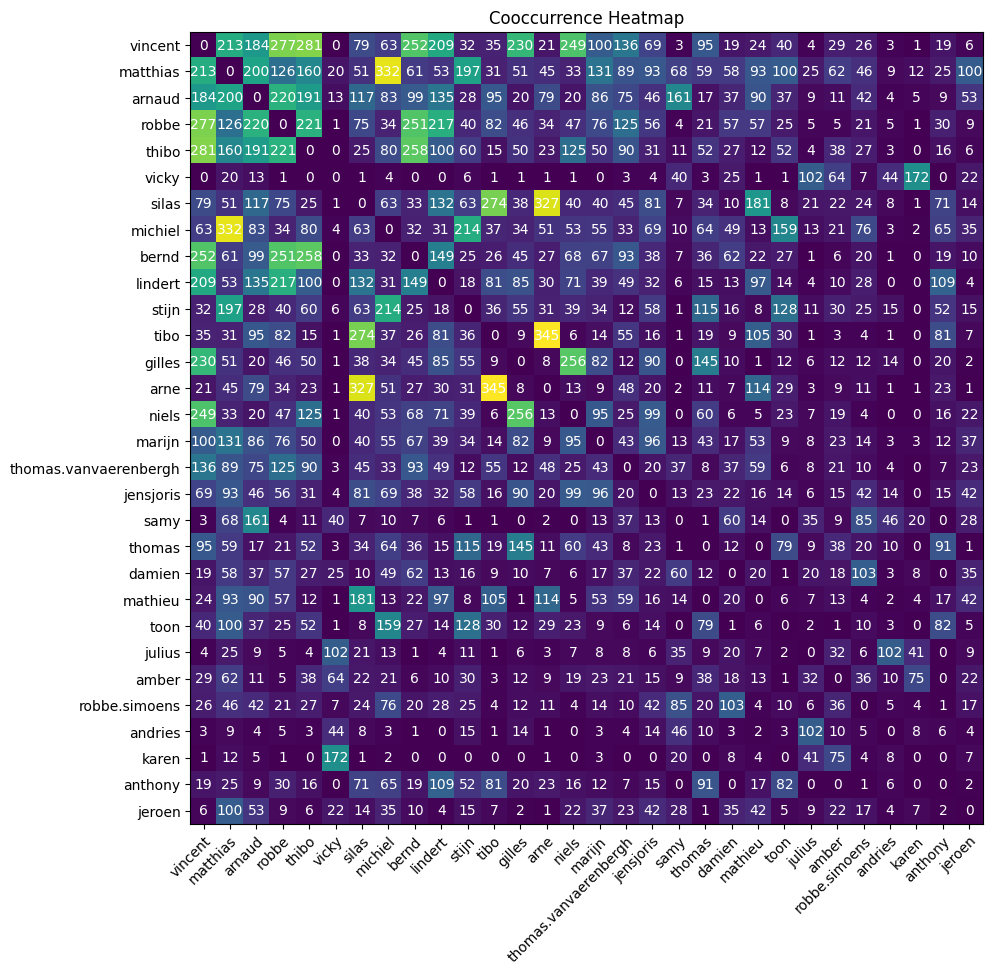

In [18]:
IC.plot_cooccurrence_heatmap(top_entities_30, figsize=10)


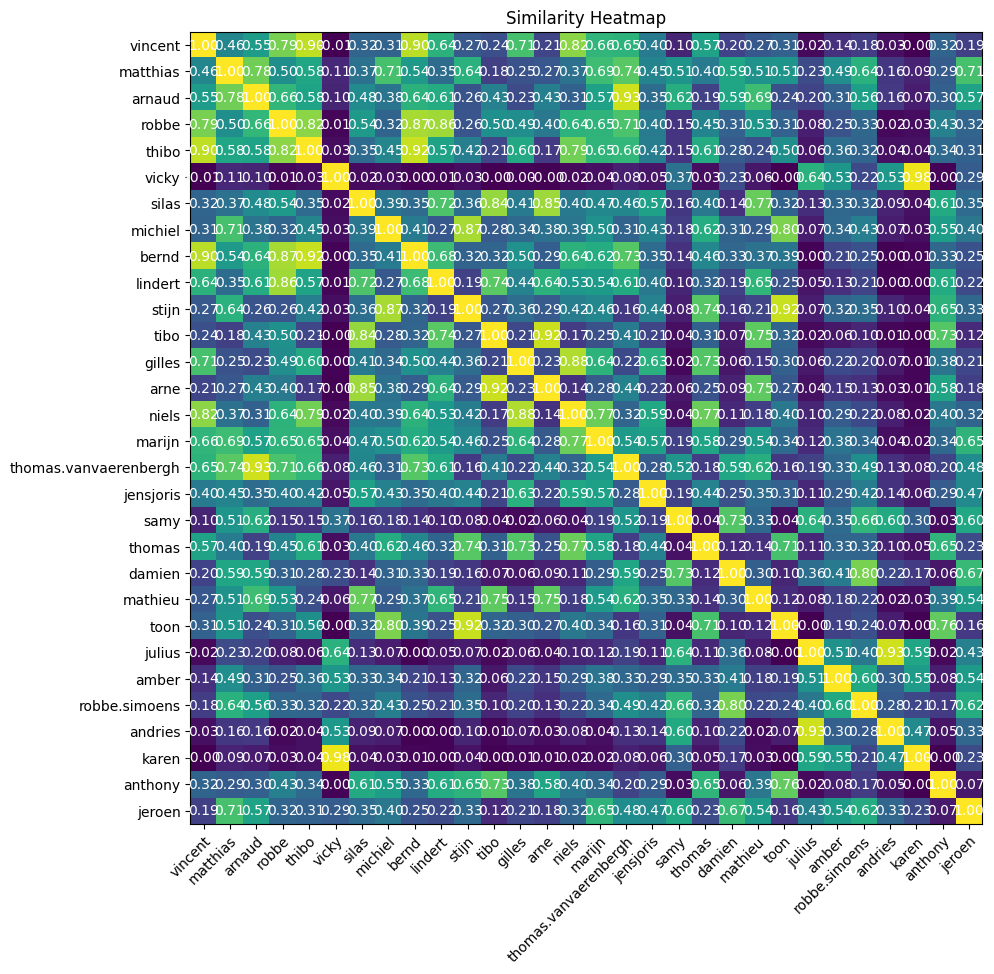

In [19]:
IC.plot_similarity_heatmap(top_entities_30, figsize=10)


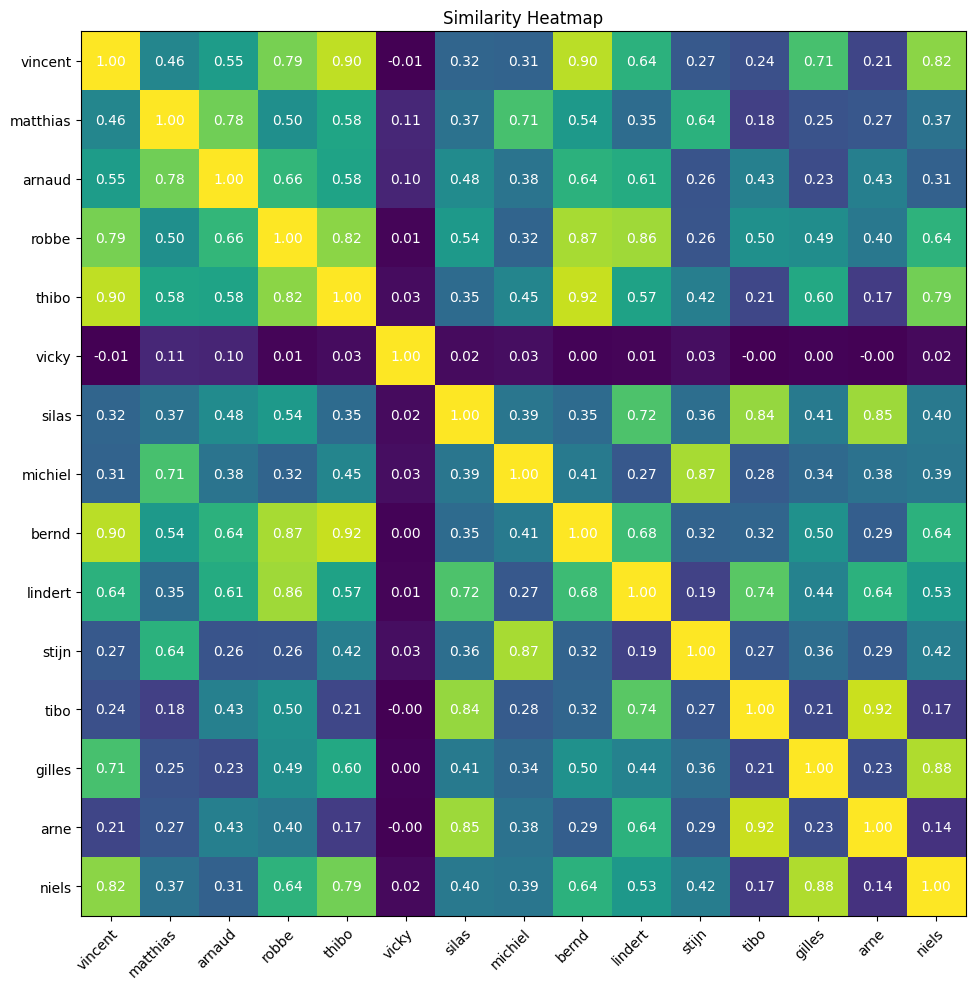

In [20]:
IC.plot_similarity_heatmap(top_entities_15, figsize=10)


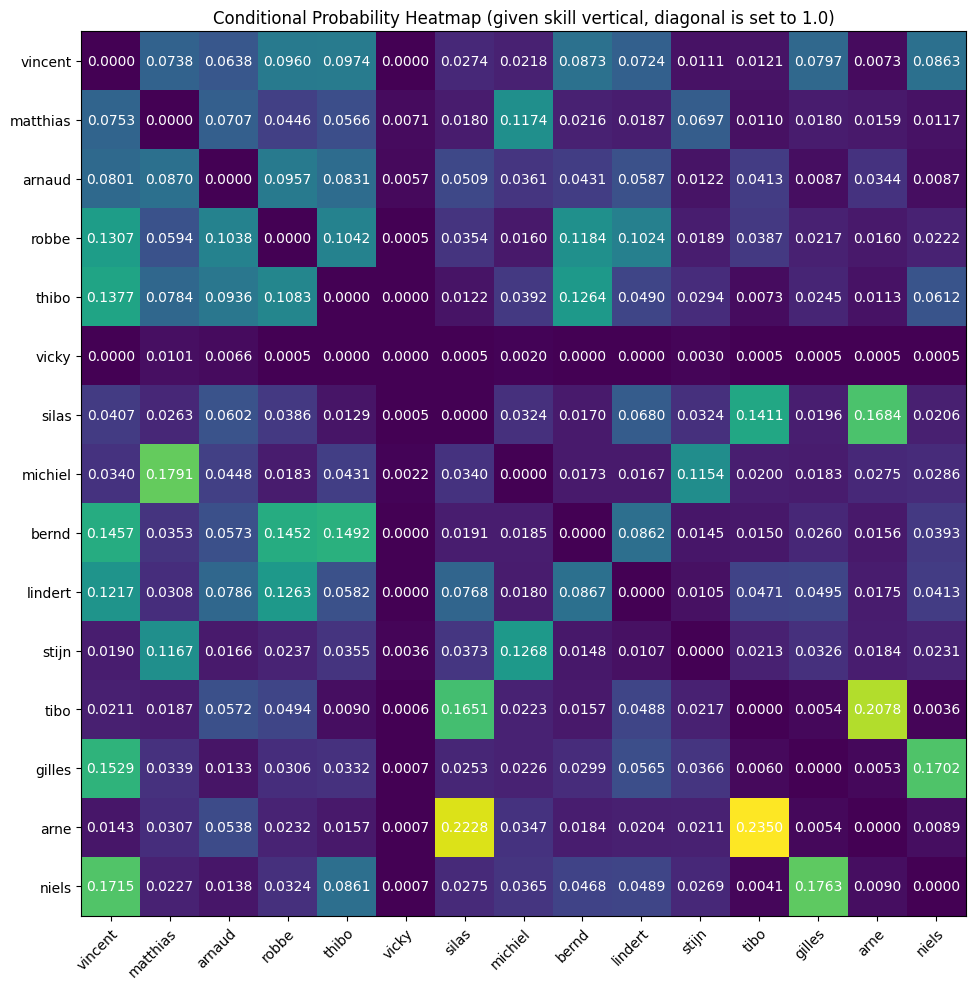

In [21]:
IC.plot_conditional_probability_heatmap(top_entities_15, figsize=10, fill_diagonal=False)


In [22]:
import numpy as np

def get_top_matches(reference_entity, candidate_entities, top_k=10):
    # Retrieve embeddings for the reference entity and candidate entities
    reference_embedding = IC.get_embeddings([reference_entity]).reshape(-1)
    candidate_embeddings = IC.get_embeddings(candidate_entities).reshape(-1, N_COMPONENTS)

    # Compute the cosine similarity between the reference and each candidate
    dot_products = np.dot(candidate_embeddings, reference_embedding)
    reference_norm = np.linalg.norm(reference_embedding)
    candidate_norms = np.linalg.norm(candidate_embeddings, axis=1)
    cosine_similarities = dot_products / (reference_norm * candidate_norms)

    # Get the top k indices with the highest cosine similarity scores
    top_k_indices = np.argsort(-cosine_similarities)[:top_k]

    # Return the top k candidate entities based on these indices
    top_matches = [candidate_entities[i] for i in top_k_indices]
    return top_matches

In [23]:
get_top_matches("marijn", occurring_readable_users)

['marijn',
 'niels',
 'matthias',
 'vincent',
 'thibo',
 'robbe',
 'jeroen',
 'gilles',
 'gabrielle.gaudeau',
 'bernd']

In [24]:
get_top_matches("niels", occurring_readable_users)

['niels',
 'gilles',
 'vincent',
 'thibo',
 'bram.desimpelaere',
 'marijn',
 'thomas',
 'jacob.demuynck',
 'simeon',
 'robbe']

In [25]:
get_top_matches("jeroen", occurring_readable_users)

['jeroen',
 'yasamin.karimi',
 'matthias',
 'andreas_de_neve',
 'margot',
 'damien',
 'julie',
 'ella.dekeyne',
 'marijn',
 'enrico']

In [26]:
get_top_matches("margot", occurring_readable_users)

['margot',
 'yasamin.karimi',
 'matthias',
 'jeroen',
 'mathieu',
 'marijn',
 'arnaud',
 'jonas.sleeuwaert',
 'michiel',
 'els.hugaerts']

In [27]:
get_top_matches("vincent", occurring_readable_users)

['vincent',
 'thibo',
 'bernd',
 'niels',
 'robbe',
 'jacob.demuynck',
 'gilles',
 'bram.desimpelaere',
 'marijn',
 'thomas.vanvaerenbergh']

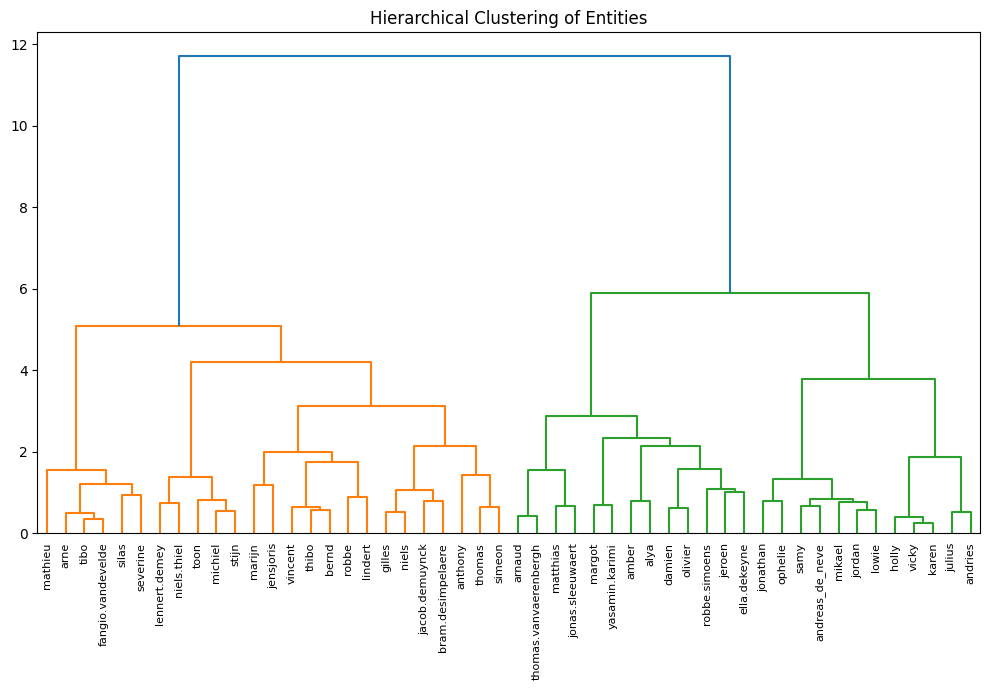

In [28]:
# Perform hierarchical clustering on the similarity matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

# Get similarity matrix
similarity_matrix = IC.get_similarity_matrix(top_entities)

# Convert similarity to distance (1 - similarity since higher similarity = closer)
distance_matrix = 1 - similarity_matrix

# Compute linkage matrix directly using scipy
Z = linkage(distance_matrix, method='ward')

# Create dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=top_entities, leaf_rotation=90)
plt.title('Hierarchical Clustering of Entities')
plt.tight_layout()
plt.show()

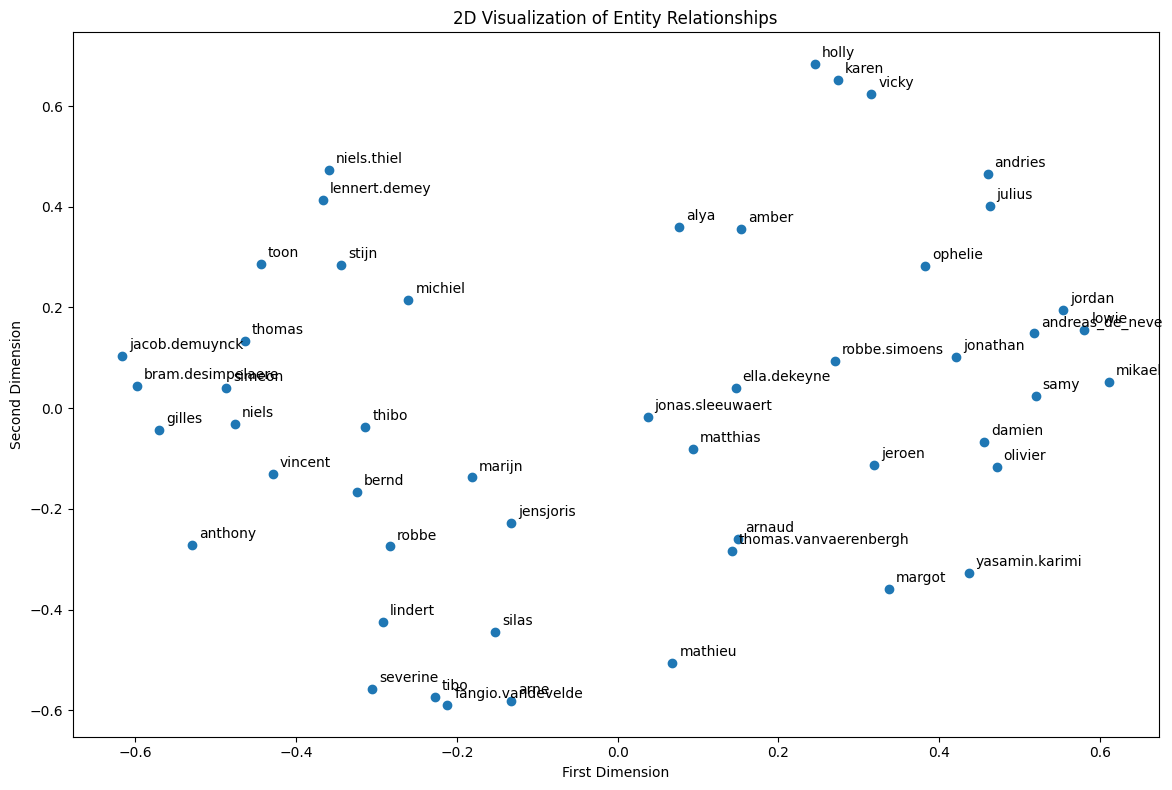

In [29]:
# Reduce dimensionality to 2D using MDS
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Create MDS model and fit to distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
coords_2d = mds.fit_transform(distance_matrix)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(coords_2d[:, 0], coords_2d[:, 1])

# Add labels for each point
for i, entity in enumerate(top_entities):
    plt.annotate(entity, (coords_2d[i, 0], coords_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('2D Visualization of Entity Relationships')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.tight_layout()
plt.show()


In [30]:
all_channels = get_filtered_channels()

In [31]:
#export all_channels to a csv file
pd.DataFrame(all_channels, columns=['channel']).to_csv('all_channels.csv', index=False)

In [32]:
work_channels = get_filtered_channels('proj-') + get_filtered_channels('opp-') + get_filtered_channels('acc-')

In [33]:
work_channels

['proj-arla-foods',
 'proj-labour-market-data-pipeline',
 'proj-experian',
 'proj-techwolf4techwolf',
 'proj-ericsson',
 'proj-automation',
 'proj-allianz',
 'proj-maqqie',
 'proj-confluence-update',
 'proj-red-hat',
 'proj-learningsphere',
 'proj-rgf-usg',
 'proj-vmo2',
 'proj-belfius',
 'proj-bosa-skills',
 'proj-hsbc',
 'proj-data-asset-playbooks',
 'proj-agoria',
 'proj-bosa-matching',
 'proj-jobat',
 'proj-ageas',
 'proj-skill-adoption-report',
 'proj-brunel',
 'proj-nbb',
 'proj-hot',
 'proj-hbr-case',
 'proj-pretty-powerbi',
 'proj-account-reviews',
 'proj-gsk-old',
 'proj-workday-integration',
 'proj-henkel',
 'proj-internal-who-are-our-customers',
 'proj-website-update',
 'proj-first-demo',
 'proj-press-release-wef',
 'proj-replacing-rchilli',
 'proj-gsk',
 'proj-here-technologies',
 'proj-gpt-skill-extraction-paper',
 'proj-everest-analytics',
 'proj-ing-be',
 'proj-teg',
 'work-proj-skill-vocabulary',
 'proj-internal-gpt-for-business-data',
 'proj-eit-food',
 'proj-ing',
 'p

In [34]:
customers = ['-arla-foods']


customer_channels = get_filtered_channels('-arla-foods') 

In [35]:
#read in labeled channels
labeled_channels = pd.read_csv('all_channels_labeled.csv')
labeled_channels


channel   work shitpost
0                         opp-ukgov   True      NaN
1                   skill-demand-mr   True      NaN
2                   proj-arla-foods   True      NaN
3                skills-hub-reports   True      NaN
4                  infosec-requests   True      NaN
..                              ...    ...      ...
952     pictures-of-your-cat-please  False     True
953                   proj-marathon   True     True
954                    proj-booking   True      NaN
955  FC:F07FNM2P6CB:🗞 7 August 2024  False      NaN
956                       opp-block   True      NaN

[957 rows x 3 columns]

In [36]:
#get all channels where 'shitpost' is True
shitpost_channels = labeled_channels[labeled_channels['shitpost'] == True]['channel'].tolist()
shitpost_channels

#get all channels where shitpost is nan
work_channels = labeled_channels[labeled_channels['shitpost'].isna()]['channel'].tolist()

In [37]:
shitpost_channels

['techwolf-love',
 'card-wolves',
 'cycling-wolves',
 'public-howling',
 'ey-scale-up-award-show',
 'interngame',
 'movember',
 'the-party-pack',
 'pasta-gang',
 'memes',
 'airfryer',
 'arts-and-craft',
 'plants',
 'cheese-appreciation-society',
 'lean-gym',
 'body-weight-olympics',
 'fc-krabbers',
 'generative-ai',
 'staalhard',
 'furry-inquisition-committee',
 'counter-espionage-naming-committee-renaming-committee',
 'pictures-of-your-kids-please',
 'wolves-of-wall-street',
 'spike-pack',
 'huuuub',
 'tennis-pack',
 'techwolf-swimming-club',
 'the-breakfast-bunch',
 'foosball',
 'whimsical-wanderers',
 'awesome-new-office',
 'couter-espionage-naming',
 'ground-travel-wolves',
 'pushup-wolves',
 'buitenkansjes',
 'techwolf-sailing-club',
 'cool-ipad-club',
 'backflips',
 'weekly-yum-yak-pictures',
 'boulder-wolves',
 'minecraft-wolves',
 'who-dun-it',
 'rave-cave',
 'beerhaikus',
 'mojo-dojo-casa-house',
 'dog-shelter-walking-club',
 'cool-chair-club',
 'non-ski-gang',
 'dungeons-and-